# Overview of Class Imbalance
(Author: Mohamad Dia, 1 September 2020)
> Note: This is a preliminary document that is supposed to give an overview of the class imbalance problem and suggest some solutions for internal use among course instructors. A more pedagogical version with code snippets or an extended blog post can be built on it later on for external use. 

## A. Why class imbalance is a problem?

Training an ML algorithm with imbalanced dataset might **create a learning bias** against the minority class(es) and consequently **affect the predictive performance** on such class(es). This is because most of the ML algorithms inherently assume balanced dataset and equal costs of errors (i.e. the cost of a false alarm is the same as the cost of a miss). Furthermore, the **performance evaluation under class-imbalance becomes more challenging**, especially when different errors are perceived with different degrees of importance (e.g. in medical applications the cost of a miss is much higher than that of a false alarm while diagnosing a fatal disease, and such costs can not be always quantified). In this case standard metrics such as accuracy, and sometimes the area under the ROC curve (AUROC), become less informative and even misleading in some high imbalance situations. Therefore, it is very essential to understand the effects of class imbalance on learning algorithms and examine how one can mitigate such effects and perform informative evaluations. We will start first by investigating the problems arising with the class imbalance.

### A.1 Prior bias (in the case of prior distribution drift between training and testing): <a name="A1"></a>

This is a problem arising in special circumstances where the class imbalance is not expected to be the same during training and testing. For instance, assume we are running a binary classification on cats and dogs images. For some reason, during the data collection, we were able to build a training dataset with 80% cats and 20% dogs. However, during testing we are expecting that our classifier will be tested on a more balanced situation where 50% of the images belong to cats and 50% belong to dogs. In such case, and assuming our classifier has *enough learning capacity*, the algorithm will inherently learn the wrong priors and lead to biased predictions at the test time.

Formally, let $x$ be the input, e.g. a cat/dog image, of a binary classifier $f(\cdot)$. You can think of $f(\cdot)$ being a logistic regression or a neural network mapping $x$ to $f(x)$. In such case, $f(x)$ represents the posterior probability of $x$ being in class $C1$, say cats, where 

\begin{equation}
f(x) = p(C1/x) \propto p(x/C_1) \times p(C1).
\end{equation}

The prediction is then made by choosing the class with higher posterior (if $f(x)>1/2$, which means $p(C1/x) > p(C2/x)$,  then it is a cat, otherwise dog).

> <sub>
In the case of logistic regression, one can easily link the posterior probability to the parameters ($w$ and $b$)
\begin{align}
p(C_1|x) = \frac{p(x|C_1)p(C_1)}{p(x)} = \frac{p(x|C_1)p(C_1)}{p(x|C_1)p(C_1) + p(x|C_2)p(C_2)}= \frac{1}{1 + \frac{p(x|C_2)p(C_2)}{p(x|C_1)p(C_1)}}
= \frac{1}{1 + \exp\left(-\ln\frac{p(x|C_1)p(C_1)}{p(x|C_2)p(C_2)}\right)} = \frac{1}{1 + \exp\left(-(w^Tx + b)\right)} = \sigma(w^Tx + b).
\end{align}
 </sub>

Assuming that the classifier has enough capacity, it will learn the *biased* training prior $p(C1)=0.8$. If we expect that such prior distribution does not hold during test time, we need to mitigate this problem. This can be done during training time (re-balance dataset via sampling/data augmentation, use penalized models) or at the test time (correct the output probability, adjust threshold) as we will see later.

### A.2 Poor predictive performance on the minority class: <a name="A2"></a>

This is a more general problem that holds even if the imbalance persists during the test time. Take for example the prediction of a fatal rare disease: the dataset is expected to be imbalanced both during training and testing, and there is no issue of distribution drift here. However, the imbalance can still affect the learning task. This is because the relatively few instances in the minority class are not enough for the algorithm to fully discover the feature space and learn the appropriate rule. Therefore, the problem here is not in learning a biased prior as in the previous section, but rather in the ability to learn the whole posterior probability.

Take the Gaussian naive Bayes classifier as an example. In case of few instance in one of the classes, we will get a poor estimation for both the prior and the Gaussian likelihood, and hence a poor performance (high generalization error).

> Note that in the previous section we had assumed that the learning algorithm has *enough learning capacity* in order to filter out this effect and focus on the prior's bias.

In order to mitigate such problem, one has to adjust the data or the model during training (data augmentation, penalized models). However, re-balancing the data or penalizing the machine learning model can create an *artificial bias* that needs to be corrected during test time. More information on this in the sequel.

### A.3 Less informative evaluation metrics: <a name="A3"></a>

The accuracy metric is meaningful for a relatively balanced dataset and for the cases where the two types of errors have the same cost (cost of false alarm = cost of miss). However, for imbalanced datasets the accuracy metrics can become misleading by giving an inflated measure that can be easily beaten by a dummy classifier. Similarly for other evaluation metrics such as the false positive rate (FPR) used in the ROC.

Lets first review different evaluation metrics in a binary classification set up:
- Accuracy $= (TP + TN)/(P+N) = (TP + TN)/(TP + FN + TN + FP)$
- TPR or recall $= TP/P = TP/(TP+FN)$
- FPR = $FP/N = FP/(FN+TN)$
- precision $= TP/(TP+FP)$

The problem with the imbalance dataset is that the majority class (usually the negative class) is overwhelming. Hence, with any reasonable classifier the $TN$ term will dominate the numerator and denominator in the accuracy and makes it close to $1$. Similarly for the false positive rate (FPR) where the dominating $TN$ term makes it always close to zero. Therefore, the accuracy and the ROC might be misleading in assessing the performance under class imbalance.

Ideally, we want both the $FN$ and $FP$ terms to be small without including the dominating $TN$ term. Hence, **it is a good practice to look at the precision and recall** which are not sensitive to the class imbalance through the $TN$ term. One way to combine these two metrics is via a harmonic mean F-1 score. This is of course under the assumptions that both types of error have the same cost. If not, one can use a weighted version of such score, e.g. F-$\beta$ score. In general, it is always recommended to look at the entire confusion matrix in such cases.

More info on F-1 score with useful visualizations [here](https://github.com/MhDia/MLteaching/blob/master/T2_F1score.ipynb).

> **Note:** The precision and recall, and hence the F-1 score, are less sensitive to class imbalance under the convention that the majority class in the negative class (i.e. the $TN$ term is relatively large than the $TP$ term). In case of a flip of convention, the precision and recall might become misleading and one needs to look at their counterpart that excludes the $TP$ terms. Therefore, it is better to stick with the convention for class imbalance (majority class being the negative class labeled by $0$ for binary classification in `sklearn`).  

## B. How to mitigate the class imbalance problem?

The effects of the class imbalance might vary based on the degree of imbalance, the amount of available data, and the type of the ML model and learning algorithm used. In some cases, one might get satisfactory performance results via standard hyper-parameter tuning and without considering further modifications in the training pipeline. However, in many other cases, especially under high imbalance and limited amount of data, one needs to address the class imbalance during the training and/or testing phases. Below are common techniques to mitigate the class imbalance problem. Such techniques can be used separately or in conjunction.

### B.1 Re-balance training dataset:<a name="B1"></a>
Try to re-balance the training dataset in favor of the minority class via the following techniques: 
- Collect more data for the minority class (if possible)
- Data augmentation of the minority class (creating synthetic samples/features, e.g. [SMOTE](https://arxiv.org/pdf/1106.1813.pdf))
- Up-sample the minority class during training
- Down-sample the majority class during training

> Note that one needs to be careful while re-balancing the training dataset. Overdoing this technique might create an *artificial bias* in the [training prior](#A1) that needs to be corrected during test time (see [B.3](#B3) below).

### B.2 Use penalized models for training (cost-sensitive models):<a name="B2"></a>
Penalize the minority class more than the majority class by adjusting the cost function. For example, if class A is twice less frequent than class B in the training dataset, define a cost function that penalizes class A more than class B. This way will make the ML model focus more on the minority class in order to compensate for the imbalance. This can be easily done in `sklearn` models by changing the `class_weight` parameter (alternatively, one can change the `sample_weight` in the `fit` method). The `'balanced'` mode in `class_weight` automatically adjusts the cost function by picking weights representing the inverse class frequencies. One can manually choose such weights and tune them during hyper-parameters tuning on the validation set. Penalized models have similar, but not exactly the same effect as the techniques mentioned in [B.1](#B1) above.

> Similarly as in [B.1](#B1), one needs to carefully choose the weights in order not to create an *artificial bias* in the training prior.

### B.3 Adjust the predictions during testing:<a name="B3"></a>
This technique is mainly used to correct the prior bias due to drift in distribution (see [A.1](#A1)) or due to artificial bias added during training. The idea is to adjust the output probabilities, or alternatively the decision threshold, at the prediction time in order to account for the bias. Take for example the binary classification problem, an ML model such as logistic regression is trained to output a prediction representing the posterior probability of an input being in class 1 or 0. The decision is then made based on the magnitude of the probabilities. If $p(x/C_1)>p(x/C_0)$ then we decide that x belongs to class 1, otherwise it belongs to class 0. The default threshold used for such binary classification is $\alpha = 1/2$, i.e. if $p(x/C_1)>\alpha$ it is believed that $x$ is in class 1. Such threshold is made based on the assumption that the prior distributions don't change between training and testing. However, this assumption might be violated due to a drift in distribution or artificial bias added during training. In this case one needs to modify the threshold $\alpha$ during testing. If the prior bias is numerically quantified, which is not usually possible, one can then compute the optimal $\alpha$ and use it at the test time. In practice, such threshold can be tuned empirically during testing.

### B.4 Use appropriate evaluation metrics:
Using evaluation metrics that are less sensitive to class imbalance and that separately assess each type of errors is very essential when evaluating the final performance. This is because many standard metrics, such as the accuracy, might become less informative and even misleading under class imbalance (as explained in [A.3](#A3) above). Some of the recommended metrics to use under class imbalance:
- Precision and recall (precision/recall curve depicts both metrics in one plot).
- F-1 score (which is a harmonic average of precision and recall). One can use a weighted version of F-1 score called the F-$\beta$ score.
- Confusion matrix to look at each type of error separately.
- Avoid misleading metrics: accuracy, FPR, TNR (a.k.a. specificity/selectivity), or any metric where the $TN$ term is dominate. The ROC and AUROC can become misleading as well for highly imbalanced datasets.

Note that choosing appropriate metrics to evaluate the final performance is usually used in conjunction with at least one of the techniques mentioned above to mitigate the class imbalance. Note also that such metrics are useful when different types of errors are perceived with different degrees of importance, even if the dataset is balanced.

## C. Python exercise

We will investigate the effect of class imbalance through a real-life example on the [Haberman Breast Cancer](https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.names) dataset. The ML task consists of applying binary classification to predict whether a patient who had undergone a surgery for breast cancer will survive or not after 5-years of operation based on three measured features. The dataset is small (306 total entries) with mild class imbalance ($26$% is the size the minority "positive" class, i.e. the patients who died within 5 years). Furthermore, this dataset presents a good use-case where the types of errors have different costs and degrees of importance: mistakenly predicting that a healthy patient will die (i.e. false alarm) is less problematic and costly than mistakenly predicting that a sick patient will survive (i.e. false miss). The first type of error might incur extra useless treatments and medications, while the second type of error might result in death! We will consider two case studies below to investigate the various problems arising with class imbalance.

Let's first load the dataset and check the degree of imbalance.

In [1]:
# Import libraries and necessary modules from scikit learn
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

In [2]:
# Load the data
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv', header=None)
X = df.values[:, :-1].astype(float)
y = df.values[:, -1]
y = y-1 #convert labels from 1/2 format to 0/1 format

In [3]:
# Compute the imbalance
pos_freq = np.round([sum(y)/len(y)],3)*100
print(" Positive class: ", (pos_freq), "%\n", "Negative class: ", (100-pos_freq), "%")

 Positive class:  [26.5] %
 Negative class:  [73.5] %


### C.1 First case study (penalized model):

In the first scenario, we will tackle the general case where there is no drift in prior distributions (i.e. the same degree of imbalance encountered during training is expected to persist during the test time). We will see how such imbalance affects the predictive performance and how to mitigate it via penalized models and the adoption of appropriate evaluation metrics.

After splitting the data randomly, we can notice that the imbalance occurs during both training and testing time.

In [4]:
# Split data for traing and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [5]:
# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Compute the imbalance on the train and test data
pos_freq_train = np.round([sum(y_train)/len(y_train)],3)*100
pos_freq_test = np.round([sum(y_test)/len(y_test)],3)*100
print("Positive class (train): ", (pos_freq_train), "%\n" "Negative class (train): ", (100-pos_freq_train), "%\n")
print("Positive class (test): ", (pos_freq_test), "%\n" "Negative class (test): ", (100-pos_freq_test), "%")

Positive class (train):  [26.3] %
Negative class (train):  [73.7] %

Positive class (test):  [26.7] %
Negative class (test):  [73.3] %


We will now train a binary classifier and evaluate its performance on the test data.

In [8]:
# Train a binary classifier (logistic regression)
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [9]:
# Predict the labels and oputput probabilities of the train/test dataset
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

The test dataset comprises 101 samples (74 negatives case and 27 positive cases). We will evaluate the performance by computing all types of events: true positive, true negative, false positive, and false negative.

In [10]:
# Compute the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_test_pred)
##print("confusion matrix: \n", conf_mat)
# Print the four events
tn, fp, fn, tp = conf_mat.ravel()
print("TN = ", tn, "FP = ", fp, "\nFN = ", fn, "TP = ", tp) #print("confusion matrix: \n", conf_mat)

TN =  69 FP =  5 
FN =  20 TP =  7


In [11]:
# Compute various metrics
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
f1 = metrics.f1_score(y_test, y_test_pred)
auroc = metrics.roc_auc_score(y_test, y_test_pred)


print(" Accuracy = ", np.round(acc,2), "\n", "Recall = ", np.round(recall,2), "\n", "Precision = ", np.round(precision,2), "\n",
      "F-1 score = ", np.round(f1,2), "\n", "AUROC = ", np.round(auroc,2))

 Accuracy =  0.75 
 Recall =  0.26 
 Precision =  0.58 
 F-1 score =  0.36 
 AUROC =  0.6


In [11]:
## Classifiucation report
#report = classification_report(y_true=y_test, y_pred=y_test_pred)
#print(report)

# ROC curve
#fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_test_prob[:, 1])
#plt.plot(fpr, tpr, label='ROC curve')
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate (Recall)')
#plt.title('ROC curve')
#plt.grid()
#plt.show()

You can notice that the classifier tends to make more false miss (20 false negatives) than false alarm (5 false positives) due to the class imbalance against the positive class. This results on a low recall and F-1 score.

We will now apply a penalized model that gives more weights for the minority class.

In [29]:
# Train a binary classifier (logistic regression) with a penalized model
model = LogisticRegression(solver='liblinear', class_weight='balanced') # class_weight={0:1,1:2}
model.fit(X_train, y_train, )

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

The `'balanced'` mode in `class_weight` automatically adjusts the cost function by picking weights representing the inverse class frequencies. One can manually choose such weights and tune them during hyper-parameters tuning.

In [30]:
# Predict the labels and output probabilities of the train/test dataset
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

In [31]:
# compute the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_test_pred)
# Print the four events
tn, fp, fn, tp = conf_mat.ravel()
print("TN = ", tn, "FP = ", fp, "\nFN = ", fn, "TP = ", tp)

TN =  59 FP =  15 
FN =  15 TP =  12


In [32]:
# Compute various metrics
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
f1 = metrics.f1_score(y_test, y_test_pred)
auroc = metrics.roc_auc_score(y_test, y_test_pred)


print(" Accuracy = ", np.round(acc,2), "\n", "Recall = ", np.round(recall,2), "\n", "Precision = ", np.round(precision,2), "\n",
      "F-1 score = ", np.round(f1,2), "\n", "AUROC = ", np.round(auroc,2))

 Accuracy =  0.7 
 Recall =  0.44 
 Precision =  0.44 
 F-1 score =  0.44 
 AUROC =  0.62


Although the accuracy decreases, you can see that the new model makes less false negatives (better recall and also better F-1 score). Depending on the objective of the ML task at hand, one can manually tune the `class_weight` and/or apply other re-balancing techniques to further improve the performance.

### C.2 Second case study (prior bias):

We will investigate here the effect of bias in priors due to drift in distributions. This is the special case where the imbalance during the test time is expected to be different than that of the training time. Of course, a priori one does not have access to the test data, but in many application scenarios one can have a rough estimate on how the class priors are distributed during the test time and whether they are different or not from the priors at the training time.

To proceed, we will purposely split the data in a way that makes a drift in distributions. Note that this an artificial example, however such situation can happen in practice where data collection during the training time does not represent the priors expected at the test time.

In [75]:
# Split the data
X, y = shuffle(X, y)

y_ind = y==1

y_train_pos = y[y_ind][:41]
X_train_pos = X[y_ind,:][:41]
y_train_neg = y[~y_ind][:185]
X_train_neg = X[~y_ind,:][:185]

y_test_pos = y[y_ind][41:]
X_test_pos = X[y_ind,:][41:]
y_test_neg = y[~y_ind][185:]
X_test_neg = X[~y_ind,:][185:]

y_train = np.concatenate((y_train_pos,y_train_neg), axis = 0)
X_train = np.concatenate((X_train_pos,X_train_neg), axis = 0)

y_test = np.concatenate((y_test_pos,y_test_neg), axis = 0)
X_test = np.concatenate((X_test_pos,X_test_neg), axis = 0)

X_train, y_train = shuffle(X_train, y_train)

In [76]:
# Compute the imbalance on the train and test data
pos_freq_train = np.round([sum(y_train)/len(y_train)],3)*100
pos_freq_test = np.round([sum(y_test)/len(y_test)],3)*100
print("Positive class (train): ", (pos_freq_train), "%\n" "Negative class (train): ", (100-pos_freq_train), "%\n")
print("Positive class (test): ", (pos_freq_test), "%\n" "Negative class (test): ", (100-pos_freq_test), "%")

Positive class (train):  [18.1] %
Negative class (train):  [81.9] %

Positive class (test):  [50.] %
Negative class (test):  [50.] %


Notice the drift in distributions. The training data is imbalanced, unlike the test data which is perfectly balanced. We will train a binary classifier and evaluate its performance on the test data.

In [77]:
# Train a binary classifier (logistic regression)
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [78]:
# Predict the labels and oputput probabilities of the train/test dataset
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)

y_test_pred = model.predict(X_test)
y_test_prob = model.predict_proba(X_test)

In [79]:
# Compute the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_test_pred)
# Print the four events
tn, fp, fn, tp = conf_mat.ravel()
print("TN = ", tn, "FP = ", fp, "\nFN = ", fn, "TP = ", tp)

TN =  39 FP =  1 
FN =  39 TP =  1


In [80]:
# Compute various metrics
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
precision = metrics.precision_score(y_test, y_test_pred)
f1 = metrics.f1_score(y_test, y_test_pred)
auroc = metrics.roc_auc_score(y_test, y_test_pred)


print(" Accuracy = ", np.round(acc,2), "\n", "Recall = ", np.round(recall,2), "\n", "Precision = ", np.round(precision,2), "\n",
      "F-1 score = ", np.round(f1,2), "\n", "AUROC = ", np.round(auroc,2))

 Accuracy =  0.5 
 Recall =  0.02 
 Precision =  0.5 
 F-1 score =  0.05 
 AUROC =  0.5


Notice how the model is biased to the negative class. Among 80 samples in the test dataset (40 positive and 40 negative), 75 where predicted to be in the negative class. This is because the model was trained on a dataset with different priors, which makes the model favor the negative class. This results in a very low recall. 

To mitigate this problem, we will modify the prediction by adjusting the output probabilities (or equivalently the decision threshold) as explained in [B.3](#B3). Remember that the binary logistic regression outputs two *posterior probabilities* for each data point using the `predict_proba` method: $p(C1/x)$ and $p(C2/x)$. The decision is then made in the `predict` method by comparing the two probabilities. If $p(C2/x) > p(C1/x)$ then the sample is predicted to be in $C2$, otherwise it is in $C1$. Note that in binary classification this is equivalent to check whether the ratio $p(C2/x)/p(C1/x)$ is greater than $\gamma = 1$ or whether $p(C2/x)$ is greater than $\alpha = 1/2$. In order to correct the drift in distribution, we need to adjust the threshold $\gamma$ (or $\alpha$). This can be empirically tuned during testing. In this special example the prior bias is numerically quantified, hence we are able to compute the optimal $\gamma$ using Bayes theorem:

\begin{equation}
\frac{p(C2/x)}{p(C1/x)} = \frac{p(x/C_2)p(C2)}{p(x/C_1)p(C1)} > \gamma = 1.
\end{equation}

Due to the drift in distributions, the priors during training ($p(C1)$ and $p(C2)$) are different than the testing priors ($p^*(C1)$ and $p^*(C2)$). In our example we have:

- $p(C1) = 0.819$ and $p(C2) = 0.181$
- $p^*(C1) = 0.5$ and $p^*(C2) = 0.5$

Therefore, we can correct this drift by adjusting the threshold. The optimal threshold $\gamma^*$ is obtained as follows

\begin{equation}
\gamma^* = \frac{p^*(C1) p(C2)}{p^*(C2) p(C1)}.
\end{equation}

This yields $\gamma^* \approx 0.22$ in our example.

Let's now apply this technique.

In [81]:
# Compute the ratio of posterior probabilities
prob_ratio = y_test_prob[:,1]/y_test_prob[:,0]

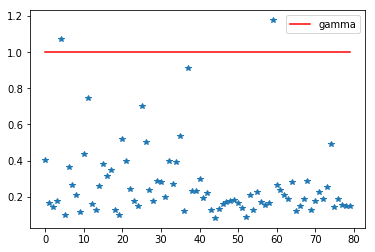

In [82]:
plt.plot(prob_ratio,'*')
plt.plot(np.ones(len(prob_ratio)),'r', label='gamma')
plt.legend()

You can see that only few samples are above the decision threshold $\gamma$. We will now correct this threshold and adjust the prediction accordingly.

In [83]:
y_test_pred_corr =  (prob_ratio >0.22).astype(int) # 0.22 is the optimal value of the decision threshold in our case

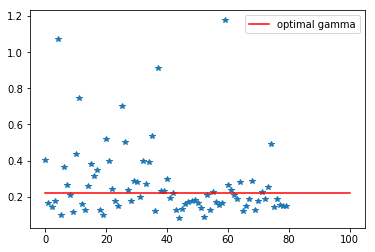

In [84]:
plt.plot(prob_ratio,'*')
plt.plot(np.ones(len(prob_ratio_corr))*0.22,'r', label='optimal gamma')
plt.legend()

In [85]:
# Compute the confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_test_pred_corr)
# Print the four events
tn, fp, fn, tp = conf_mat.ravel()
print("TN = ", tn, "FP = ", fp, "\nFN = ", fn, "TP = ", tp)

TN =  29 FP =  11 
FN =  15 TP =  25


In [86]:
# Compute various metrics
acc = metrics.accuracy_score(y_test, y_test_pred_corr)
recall = metrics.recall_score(y_test, y_test_pred_corr)
precision = metrics.precision_score(y_test, y_test_pred_corr)
f1 = metrics.f1_score(y_test, y_test_pred_corr)
auroc = metrics.roc_auc_score(y_test, y_test_pred_corr)


print(" Accuracy = ", np.round(acc,2), "\n", "Recall = ", np.round(recall,2), "\n", "Precision = ", np.round(precision,2), "\n",
      "F-1 score = ", np.round(f1,2), "\n", "AUROC = ", np.round(auroc,2))

 Accuracy =  0.68 
 Recall =  0.62 
 Precision =  0.69 
 F-1 score =  0.66 
 AUROC =  0.68


You can clearly notice the great improvement in performance after changing the decision threshold.

References and useful links/libraries:
- The impact of class imbalance in classification performance metrics based on the binary confusion matrix (paper). https://www.sciencedirect.com/science/article/pii/S0031320319300950
- Classification of imbalanced data: a review (paper). https://www.researchgate.net/publication/263913891_Classification_of_imbalanced_data_a_review#read
- The Effects of Class Imbalance and Training Data Size on Classifier Learning: An Empirical Study (paper). https://link.springer.com/article/10.1007/s42979-020-0074-0
- The Class Imbalance Problem (book chapter). https://link.springer.com/content/pdf/10.1007%2F978-3-319-47194-5_3
- The Impact of Class Rebalancing Techniques on the Performance and Interpretation of Defect Prediction Models (paper). https://arxiv.org/pdf/1801.10269.pdf
- 8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset (blog post). https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
- Imbalanced-learn library. https://imbalanced-learn.readthedocs.io/en/stable/index.html